# Intro - Fruit and Vegetable Image Recognition

Original dataset [found here](https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition).

(Thank you Timur for your [awesome spreadsheet!](https://docs.google.com/spreadsheets/d/1xsPRZTY8TetcZhvtqAZQ8CLj-uIRakfFa8zQ9wSBOWo/edit#gid=0))

The goal of this project is to solve an image classification problem dealing with fruits and vegetables.

This dataset contains images of the following food items:

* Fruits: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
* Vegetables: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant.

This dataset contains three folders:

* train (100 images each)
* test (10 images each)
* validation (10 images each)

Each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present.

# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import dask.bag as db
import dask.diagnostics as dd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications.xception as xc
from tensorflow import keras

# Exploratory Data Analysis

Since we're not dealing with tabular data, the Exploratory Data Analysis we can do is slightly different that what we've seen so far in the ML Zoomcamp course. We cannot look for null values nor calculate metrics such as correlation, risk ratio or mutual information. However, we can explore our class distribution and the nature of our images.

## Dataframe creation

We create a series of dataframes to make it easier to handle file paths.

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('./data/veggies/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/veggies/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/veggies/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
        Source: https://www.kaggle.com/databeru/fruit-and-vegetable-classification/
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

## Basic information about our train dataset

Let's take a look at our available classes and number of images.

In [4]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3193

Number of different labels: 36

Labels: ['pomegranate' 'pineapple' 'soy beans' 'pear' 'jalepeno' 'cauliflower'
 'cabbage' 'orange' 'onion' 'turnip' 'garlic' 'cucumber' 'banana'
 'sweetpotato' 'capsicum' 'beetroot' 'corn' 'chilli pepper' 'tomato'
 'mango' 'ginger' 'spinach' 'sweetcorn' 'apple' 'eggplant' 'peas'
 'raddish' 'bell pepper' 'watermelon' 'lettuce' 'grapes' 'potato' 'lemon'
 'carrot' 'kiwi' 'paprika']


In [5]:
train_df

,Filepath,Label
0,data/veggies/train/pomegranate/Image_72.jpg,pomegranate
1,data/veggies/train/pineapple/Image_88.jpg,pineapple
2,data/veggies/train/soy beans/Image_17.jpg,soy beans
3,data/veggies/train/pear/Image_88.jpg,pear
4,data/veggies/train/jalepeno/Image_78.jpg,jalepeno
...,...,...
3188,data/veggies/train/carrot/Image_64.jpg,carrot
3189,data/veggies/train/pear/Image_4.jpg,pear
3190,data/veggies/train/jalepeno/Image_6.jpg,jalepeno
3191,data/veggies/train/capsicum/Image_35.jpg,capsicum


In [6]:
train_df['Label'].describe()

count            3193
unique             36
top       sweetpotato
freq               97
Name: Label, dtype: object

## Class distribution

Next, we take a look at the amount of images per class to check for any imbalances or biases.

In [7]:
plot_info = train_df['Label'].value_counts()

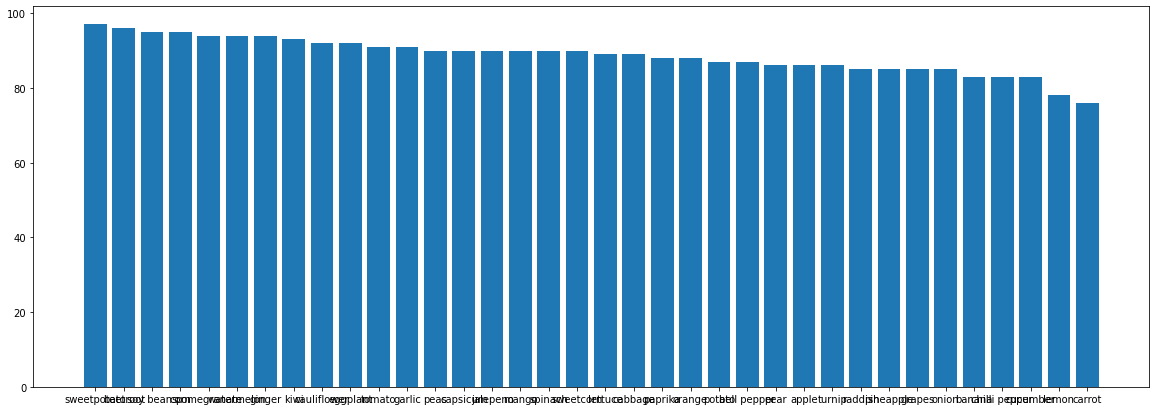

In [8]:
plt.figure(figsize=(20,7))
plt.bar(plot_info.axes[0].tolist(), plot_info.values.tolist())
plt.show()

In [9]:
plot_info.describe()

count    36.000000
mean     88.694444
std       4.791775
min      76.000000
25%      85.750000
50%      89.500000
75%      92.000000
max      97.000000
Name: Label, dtype: float64

In [10]:
plot_info.mode()

0    90
dtype: int64

We find that some classes are more represented than others, but the standard deviation is pretty small. However, given that we do not have a large amount of images, training the model might prove challenging.

## Image visualization

We take a look at some sampled images. Manually revising every image can be very time consuming, but we can take a quick look at some images to check things such as how centered the objects are in the image, background details, etc.

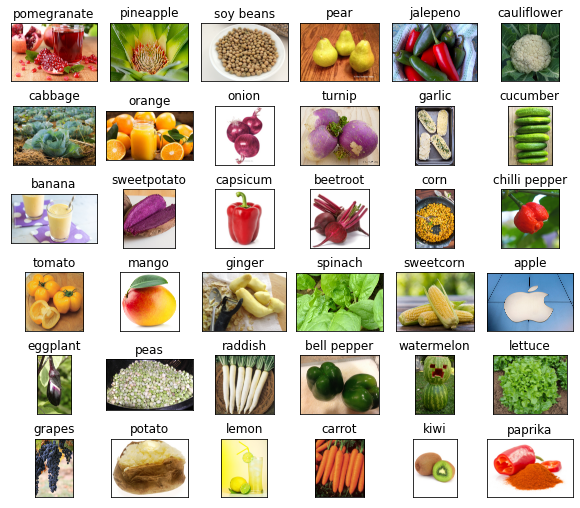

In [11]:
""" Source: https://www.kaggle.com/databeru/fruit-and-vegetable-classification/
"""

# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

Some things of note:

* The sample image for `sweetpotato` is actually the flower, not the tuber.
* The sample image for `raddish` seems to be sliced pickled raddish.
* The sample image for `cabbage` is some sort of cooked dish where the cabbage is barely recognizable.
* The sample image for `potato` has a human face photoshopped on a potato.
* The sample image for `cauliflower` is of cooked cauliflower in a pot.

Looking at random samples of the dataset tells us that some categories may contain very different representations of the same class, which may make training more difficult and make our models perform worse.

## Image size

Let's finally take a look at the sizes of the images we're dealing with.

In [12]:
labels = train_df.Label.unique()

In [13]:
def get_label_directory(label):
    path = 'data/veggies/train/'
    return f'{path}{label}/'

paths = []
for l in labels:
    paths.append(get_label_directory(l))

In [14]:
labels_dict = dict(zip(labels, paths))

In [15]:
def get_dims(file):
    ''' Returns dimensions for an RGB image
    '''
    im = Image.open(file)
    arr = np.array(im)
    # png array shape has only 2 elements instead of jpg's 3 elements
    if len(arr.shape) == 2:
        h,w = arr.shape
    else:
        h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.9s
[########################################] | 100

/Users/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.0s
[########################################] | 100

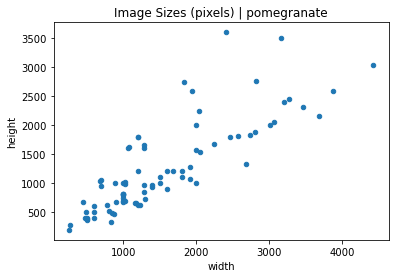

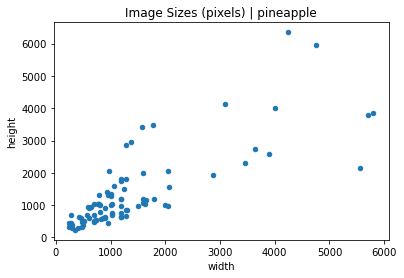

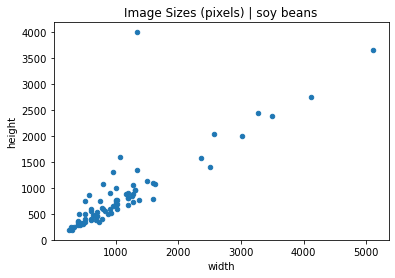

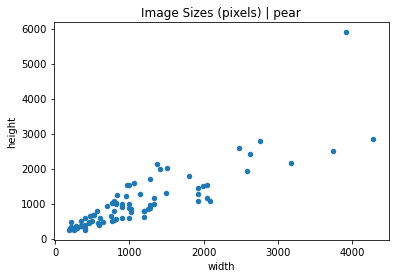

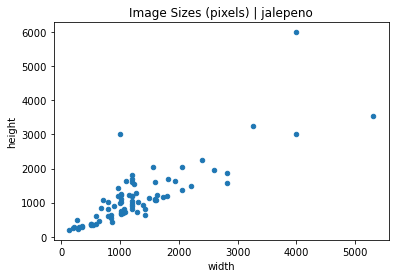

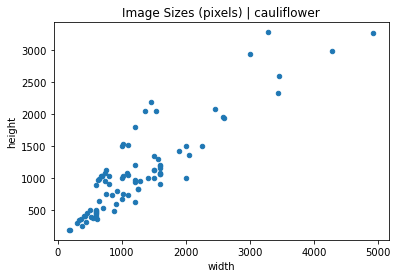

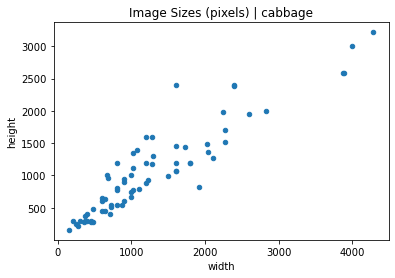

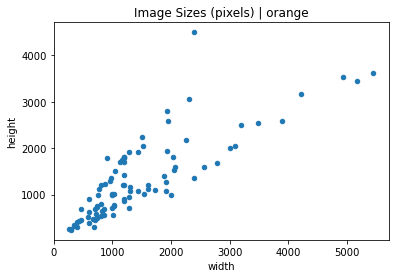

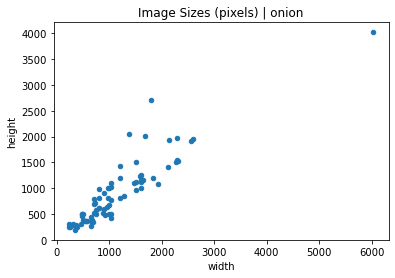

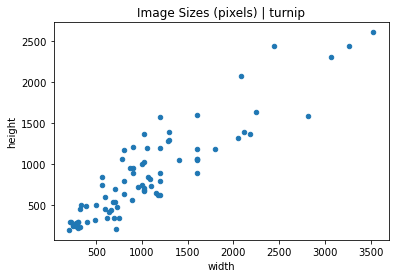

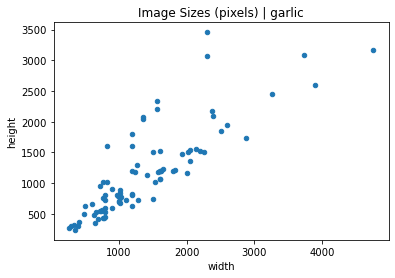

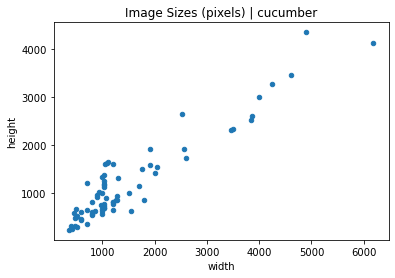

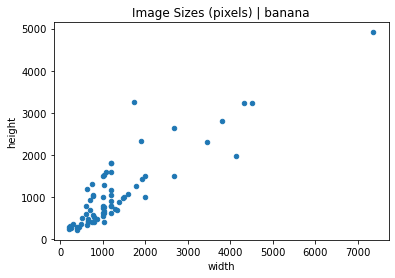

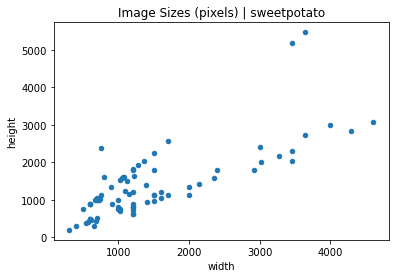

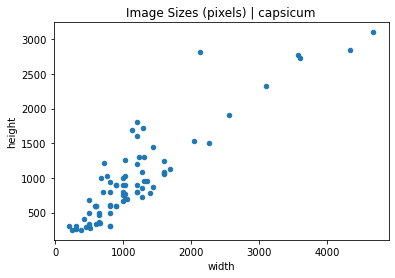

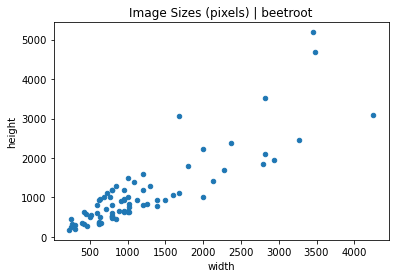

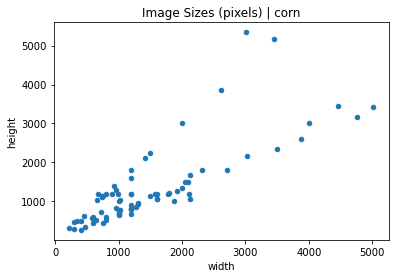

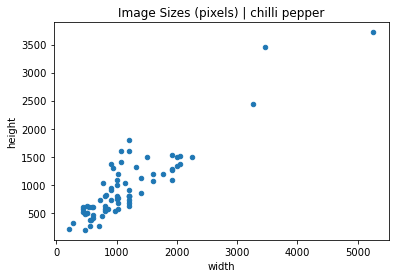

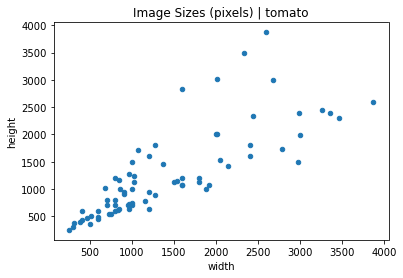

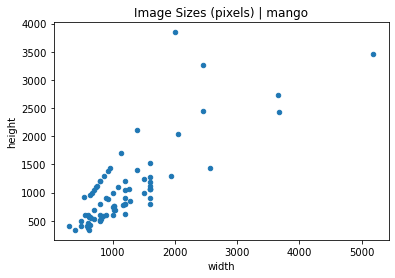

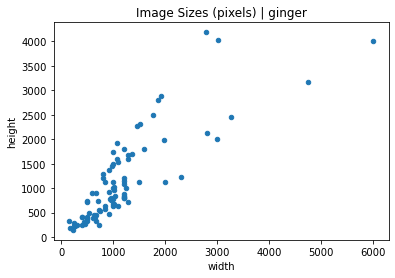

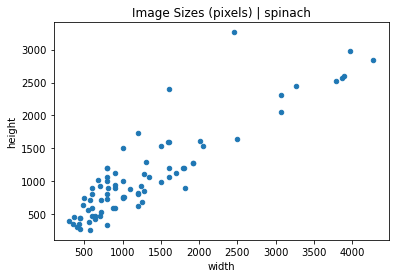

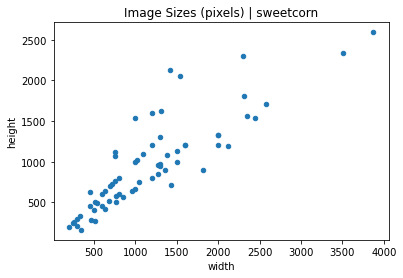

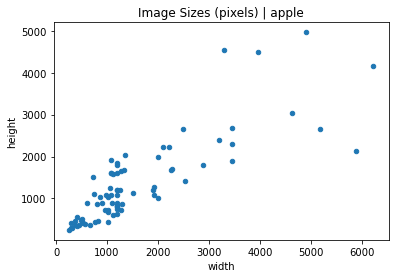

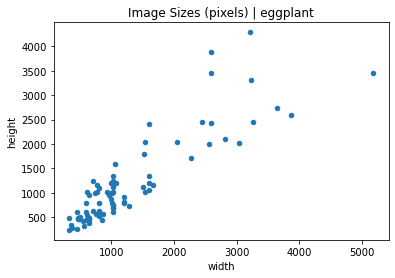

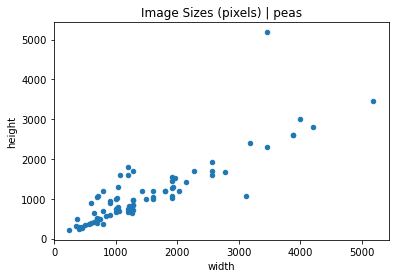

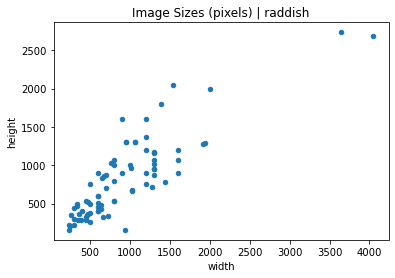

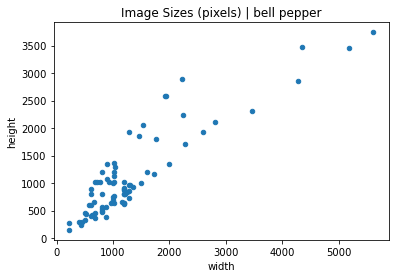

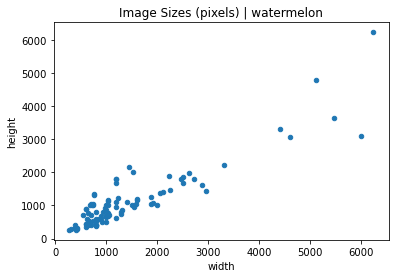

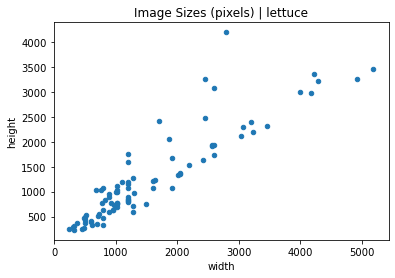

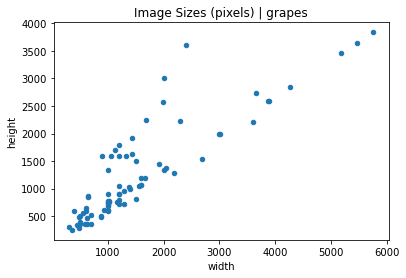

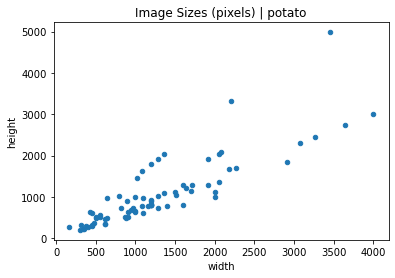

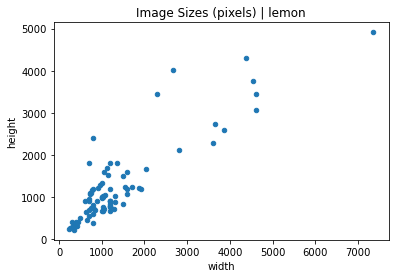

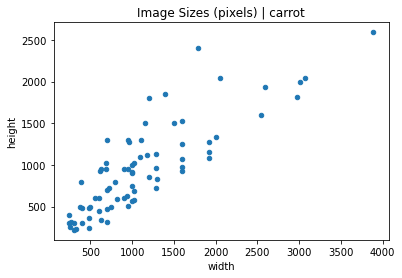

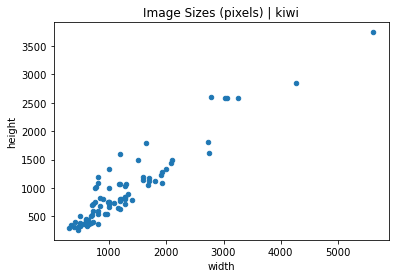

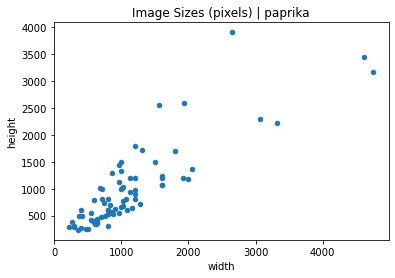

In [16]:
for l,d in labels_dict.items():
    """ Source: https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
    """
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = db.from_sequence(filelist).map(get_dims)
    with dd.ProgressBar():
        dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height')
    plt.title('Image Sizes (pixels) | {}'.format(l))
    

Image sizes are all over the place. Every single class contains a small amount of very large images as well as an amount of very small images.

# Xception

In [17]:
train_gen = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

train_ds = train_gen.flow_from_dataframe(
    dataframe= train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen = ImageDataGenerator(
    preprocessing_function=xc.preprocess_input
)

val_ds = val_gen.flow_from_dataframe(
    dataframe= val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [18]:
def make_xception_model():
    base_model = xc.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense1 = keras.layers.Dense(128, activation='relu')(vectors)
    dense2 = keras.layers.Dense(128, activation='relu')(dense1)
    outputs = keras.layers.Dense(36)(dense2)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=1e-3),
        loss = keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    return model



In [19]:
model_xc = make_xception_model()
model_xc.summary()

2021-12-07 17:54:01.450074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                4644      
Total params: 21,144,908
Trainable params: 283,428
Non-trainable params: 20,861,480
___________________________________________

In [20]:
history = model_xc.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    batch_size=32
)

2021-12-07 17:54:04.491889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
 52/100 [==============>...............] - ETA: 1:49 - loss: 2.4477 - accuracy: 0.4062

/Users/ziri/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - 267s 3s/step - loss: 1.8208 - accuracy: 0.5337 - val_loss: 0.5188 - val_accuracy: 0.8653
Epoch 2/10
100/100 [==============================] - 258s 3s/step - loss: 0.7528 - accuracy: 0.7682 - val_loss: 0.3448 - val_accuracy: 0.8832
Epoch 3/10
100/100 [==============================] - 272s 3s/step - loss: 0.5276 - accuracy: 0.8324 - val_loss: 0.2312 - val_accuracy: 0.9311
Epoch 4/10
100/100 [==============================] - 267s 3s/step - loss: 0.3704 - accuracy: 0.8898 - val_loss: 0.1834 - val_accuracy: 0.9341
Epoch 5/10
100/100 [==============================] - 275s 3s/step - loss: 0.2903 - accuracy: 0.9079 - val_loss: 0.1389 - val_accuracy: 0.9551
Epoch 6/10
100/100 [==============================] - 277s 3s/step - loss: 0.2200 - accuracy: 0.9295 - val_loss: 0.1253 - val_accuracy: 0.9611
Epoch 7/10
 99/100 [============================>.] - ETA: 2s - loss: 0.1787 - accuracy: 0.9405

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()